# Set-up

In [265]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import seaborn as sns
import numpy as np
import random

sns.set_theme()
colors = sns.color_palette("deep")
seq_colors = sns.color_palette("rocket")

from math import floor, ceil, sqrt
from NMF_iter import functional_norm, normalize_curves
from scipy.stats import levene

from itertools import permutations

In [155]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [156]:
def plot_components(H_dict, nrows=None, ncols=None, figsize=(20, 10)):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(H_dict)))
        ncols = ceil(len(H_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    for idx, (method, H) in enumerate(H_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        abscissa = np.linspace(0, 24, H.shape[1])
        for k in range(H.shape[0]):
            label = f'Component {k + 1}'
            if 'smoothed' in method:
                marker=None
            else:
                marker = 'o'
            axs[i,j].plot(abscissa, H[k, :], marker=marker, linestyle='-', label=label)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [157]:
def plot_residual_curves(residuals_dict, n_curves_plotted=10, nrows=None, ncols=None, figsize=(20, 10), **kwargs):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(residuals_dict)))
        ncols = ceil(len(residuals_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    curves_to_plot = random.sample(range(next(iter(residuals_dict.values())).shape[0]), n_curves_plotted)

    for idx, (method, resid) in enumerate(residuals_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        for n in curves_to_plot:
            axs[i,j].plot(resid.iloc[n, :], marker='o', linestyle='-', **kwargs)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        # axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [158]:
def plot_residual_boxplots(residuals_with_info, nrows=None, ncols=None, figsize=(20, 10), rotate_xlabels=False, **kwargs):
    nrows = floor(sqrt(len(residuals_with_info)))
    ncols = ceil(len(residuals_with_info) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharex=True, sharey=True)

    for idx, (method, resid_df)  in enumerate(residuals_with_info.items()):
        i = idx // ncols
        j = idx % ncols
        sns.boxplot(
            resid_df,
            y='residual',
            ax=axs[i, j],
            **kwargs
        )
        axs[i, j].set_title(method)
        if rotate_xlabels:
            axs[i, j].tick_params(axis='x', rotation=45)
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [159]:
def plot_random_reconstructed(reconstructed, X, n_obs=4, override_methods=None, figsize=(20,10), **kwargs):
    nrows = floor(sqrt(n_obs))
    ncols = ceil(n_obs / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharex=True, sharey=True)
    
    first_element = next(iter(reconstructed.values()))
    random_curves_idx = random.sample(first_element.index.to_list(), n_obs)

    for idx, name in enumerate(random_curves_idx):
        i = idx // ncols
        j = idx % ncols
        for method, recons in reconstructed.items():
            if override_methods:
                if method in override_methods:
                    axs[i,j].plot(recons.loc[name], marker='o', linestyle='-', label=method, **kwargs)
            else:
                axs[i,j].plot(recons.loc[name], marker='o', linestyle='-', label=method, **kwargs)
        axs[i,j].plot(X.loc[name], marker='o', linestyle='-', label='True curve', **kwargs)
        axs[i,j].set_xlabel('Hour')
        axs[i,j].set_title(name)
        axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [160]:
info_cols = ['region', 'year', 'month', 'daytype']

def plot_concentrations_boxplots(
        W_with_info,
        nrows=None,
        ncols=None,
        figsize=(20, 10),
        rotate_xlabels=False,
        title=None,
        replicate_legend=True,
        subplots_titles=None,
        legend_position=None,
        ncols_legend=None,
        **kwargs
    ):
    nrows = floor(sqrt(len(W_with_info)))
    ncols = ceil(len(W_with_info) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharex=True, sharey=True)

    for idx, (method, W_df)  in enumerate(W_with_info.items()):
        i = idx // ncols
        j = idx % ncols
        sns.boxplot(
            W_df.melt(id_vars=info_cols, var_name='component', value_name='concentration'),
            y='concentration',
            ax=axs[i, j],
            **kwargs
        )
        if subplots_titles:
            axs[i, j].set_title(subplots_titles[idx])
        else:
            axs[i, j].set_title(method)
        
        if not replicate_legend and idx != 0:
            axs[i, j].get_legend().remove()

        if rotate_xlabels:
            axs[i, j].tick_params(axis='x', rotation=45)

        if ncols_legend:
            ncols_legend = {'ncols': ncols_legend}
        else:
            ncols_legend = {}

        if legend_position:
            axs[i, j].legend(bbox_to_anchor=(1, 1), loc=legend_position, **ncols_legend)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [233]:
def align_components(H, W, ref_method, to_align_methods):
    # Align the components
    ref_H = H[ref_method]
    ref_n_comp, ref_n_eval_points = ref_H.shape
    ref_eval_points = np.arange(0, ref_n_eval_points, int(ref_n_eval_points / 24))

    for method in to_align_methods:

        n_comp, n_eval_points = H[method].shape
        best_permutation = list(range(n_comp))
        eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
        best_alignment = np.linalg.norm(ref_H[:, ref_eval_points] - H[method][np.ix_(range(ref_n_comp), eval_points)], 'fro')

        for permutation in list(permutations(range(n_comp))):
            alignment = np.linalg.norm(ref_H[:, ref_eval_points] - H[method][np.ix_(list(permutation)[:ref_n_comp], eval_points)], 'fro')

            if alignment < best_alignment:
                best_alignment = alignment
                best_permutation = list(permutation)

        H[method] = H[method][best_permutation, :]
        W[method] = W[method][:, best_permutation]

In [162]:
max_n_components = 6
colormap = ListedColormap([colors[k] for k in range(max_n_components)])

# Load results and input data

## NMF Results

In [234]:
method_names = [
    # 'WHopt_3comp_1000runs',
    'WHopt_3comp_10000runs',
    'WHopt_3comp_smoothed_1000runs',
    'FPCA_3PCs',
    # 'WHopt_4comp_1000runs',
    'WHopt_4comp_10000runs',
    # 'WHopt_bis_4comp_1000runs.npz'
    'WHopt_4comp_smoothed_1000runs',
    # 'WHopt_4comp_smoothed_10000runs',
    'FPCA_4PCs',
    # 'WHopt_5comp_1000runs',
    # 'WHopt_6comp_1000runs',
]

nmf_method_names = [method for method in method_names if 'PCA' not in method]

W = {}
H = {}

for method in nmf_method_names:
    data = np.load('data/nmf_results/' + method + '.npz', allow_pickle=True)
    W[method] = data['W']
    H[method] = data['H']

In [235]:
# Align the components between the ref methods
ref_method = 'WHopt_3comp_10000runs'
align_components(H, W, ref_method, nmf_method_names)

# Align components for the more than 3 comp methods
ref_method = 'WHopt_4comp_10000runs'
to_align_methods = [method for method in nmf_method_names if (('4comp' in method) or ('5comp' in method) or ('6comp' in method))  and method != ref_method]
align_components(H, W, ref_method, to_align_methods)

# # Align components for the 4comp methods
# ref_method = 'WHopt_4comp_1000runs'
# to_align_methods = [method for method in nmf_method_names if '4comp' in method and method != ref_method]
# align_components(H, W, ref_method, to_align_methods)

## Input data

In [236]:
input_df = pd.read_csv('data/daily_curves_fixed.csv', index_col=0)
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
print(len(df))
df.head(3)

11646


0        1        2        3        4  \
Calabria_2021-01-02_Saturday     552.943  514.861  462.221  448.924  457.576   
Calabria_2021-01-03_Holiday      518.853  457.879  432.200  419.060  393.992   
Calabria_2021-01-04_Working day  540.431  450.024  434.019  432.949  435.210   

                                       5        6        7        8        9  \
Calabria_2021-01-02_Saturday     462.207  492.594  526.408  579.682  648.228   
Calabria_2021-01-03_Holiday      438.706  462.433  488.501  532.412  641.866   
Calabria_2021-01-04_Working day  457.071  516.980  625.155  691.067  885.798   

                                 ...       19       20       21       22  \
Calabria_2021-01-02_Saturday     ...  828.180  831.509  758.732  669.630   
Calabria_2021-01-03_Holiday      ...  819.056  825.176  754.773  706.062   
Calabria_2021-01-04_Working day  ...  980.735  926.445  845.014  756.975   

                                      23       24    region  year  month  \
Calabria_2021-01-02_Saturday     596.548  518.853  Calabria  2021     01   
Calabria_2021-01-03_Holiday      629.708  540.431  Calabria  2021     01   
Calabria_2021-01-04_Working day  688.183  601.762  Calabria  2021     01   

                                     daytype  
Calabria_2021-01-02_Saturday        Saturday  
Calabria_2021-01-03_Holiday          Holiday  
Calabria_2021-01-04_Working day  Working day  

[3 rows x 29 columns]

In [237]:
X = df.drop(unit_info.columns, axis=1)
# We want to keep a functional l1 norm of 1. In case of 15min interval load measures (so 97 measures), we normalise by the l1 norm of the vector divided by int(97 / 24) = 4
X = normalize_curves(X)
X.head()

0         1         2         3  \
Calabria_2021-01-02_Saturday     0.036819  0.034283  0.030778  0.029892   
Calabria_2021-01-03_Holiday      0.034625  0.030556  0.028842  0.027966   
Calabria_2021-01-04_Working day  0.030835  0.025677  0.024763  0.024702   
Calabria_2021-01-05_Working day  0.034956  0.031889  0.030023  0.029715   
Calabria_2021-01-06_Holiday      0.033561  0.029616  0.028412  0.028415   

                                        4         5         6         7  \
Calabria_2021-01-02_Saturday     0.030469  0.030777  0.032800  0.035052   
Calabria_2021-01-03_Holiday      0.026293  0.029277  0.030860  0.032600   
Calabria_2021-01-04_Working day  0.024831  0.026079  0.029497  0.035669   
Calabria_2021-01-05_Working day  0.028913  0.030107  0.033811  0.039218   
Calabria_2021-01-06_Holiday      0.027903  0.028700  0.029924  0.032797   

                                        8         9  ...        15        16  \
Calabria_2021-01-02_Saturday     0.038599  0.043163  ...  0.043207  0.043862   
Calabria_2021-01-03_Holiday      0.035530  0.042834  ...  0.045282  0.044483   
Calabria_2021-01-04_Working day  0.039430  0.050540  ...  0.048232  0.045538   
Calabria_2021-01-05_Working day  0.043283  0.053841  ...  0.046168  0.044271   
Calabria_2021-01-06_Holiday      0.035796  0.046258  ...  0.046951  0.044372   

                                       17        18        19        20  \
Calabria_2021-01-02_Saturday     0.049662  0.051500  0.055146  0.055368   
Calabria_2021-01-03_Holiday      0.048738  0.050998  0.054659  0.055067   
Calabria_2021-01-04_Working day  0.049652  0.050852  0.055957  0.052859   
Calabria_2021-01-05_Working day  0.047506  0.051417  0.051633  0.050358   
Calabria_2021-01-06_Holiday      0.047203  0.051273  0.052255  0.050949   

                                       21        22        23        24  
Calabria_2021-01-02_Saturday     0.050522  0.044589  0.039722  0.034549  
Calabria_2021-01-03_Holiday      0.050369  0.047118  0.042023  0.036065  
Calabria_2021-01-04_Working day  0.048213  0.043190  0.039265  0.034334  
Calabria_2021-01-05_Working day  0.046345  0.040047  0.035615  0.030337  
Calabria_2021-01-06_Holiday      0.048430  0.044395  0.040193  0.035674  

[5 rows x 25 columns]

## PCA-reconstructed signal

In [238]:
n_pcs = [3, 4]
X_fpca = {}

for k in n_pcs:
    X_fpca[f'FPCA_{k}PCs'] = pd.read_csv(f'data/daily_curves_reconstructed_{k}PCs.csv', index_col=0)
    X_fpca[f'FPCA_{k}PCs'].columns = pd.to_numeric(X_fpca[f'FPCA_{k}PCs'].columns)

# Compare profiles found

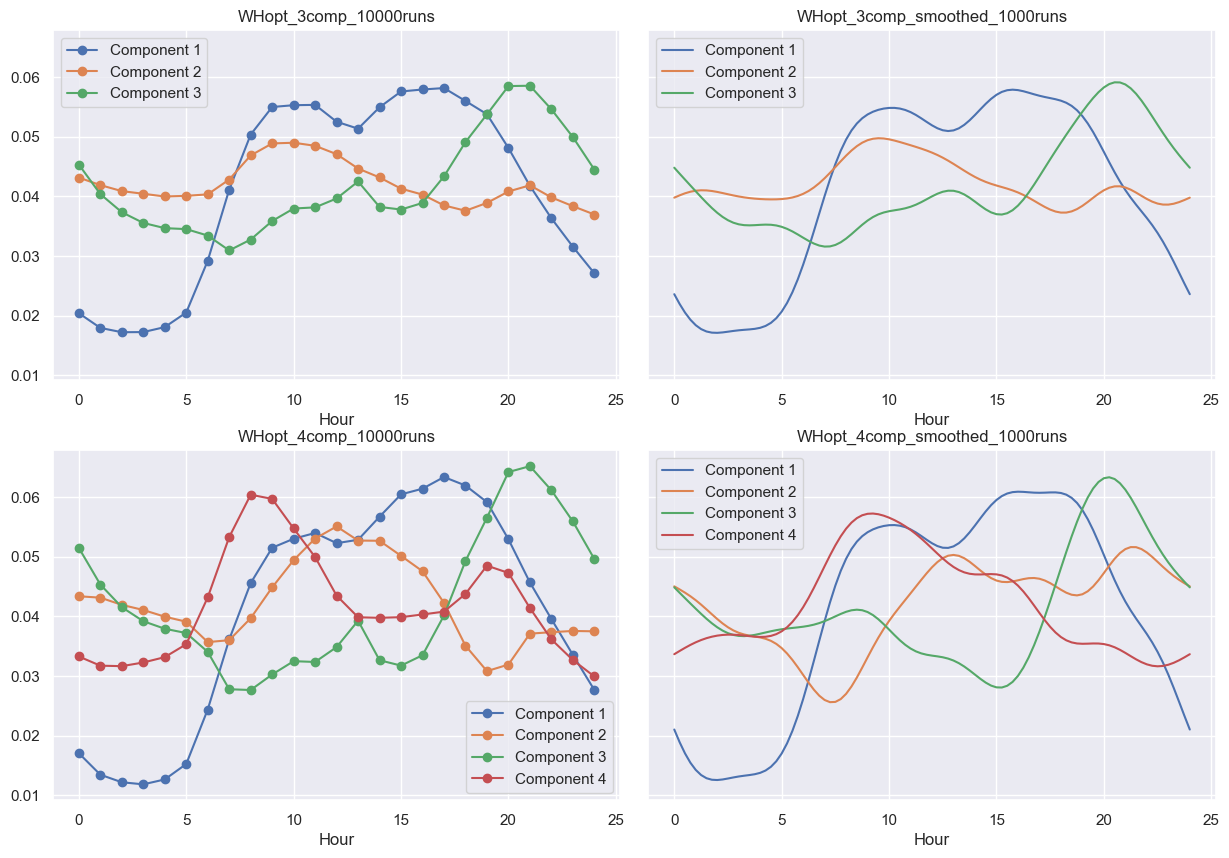

In [239]:
fig, axs = plot_components(H, figsize=(15, 10))

# Assess assumptions on the residuals

In [240]:
reconstructed = {}
residuals = {}

for method in method_names:
    if method not in nmf_method_names:
        reconstructed[method] = X_fpca[method]
    else:
        reconstructed_smooth = np.dot(W[method], H[method])
        n_eval_points = H[method].shape[1]
        reconstructed[method] = pd.DataFrame(reconstructed_smooth[:, np.arange(0, n_eval_points, int(n_eval_points / 24))], index=input_df.index)

    residuals[method] = X.values - reconstructed[method]

## Residual curves

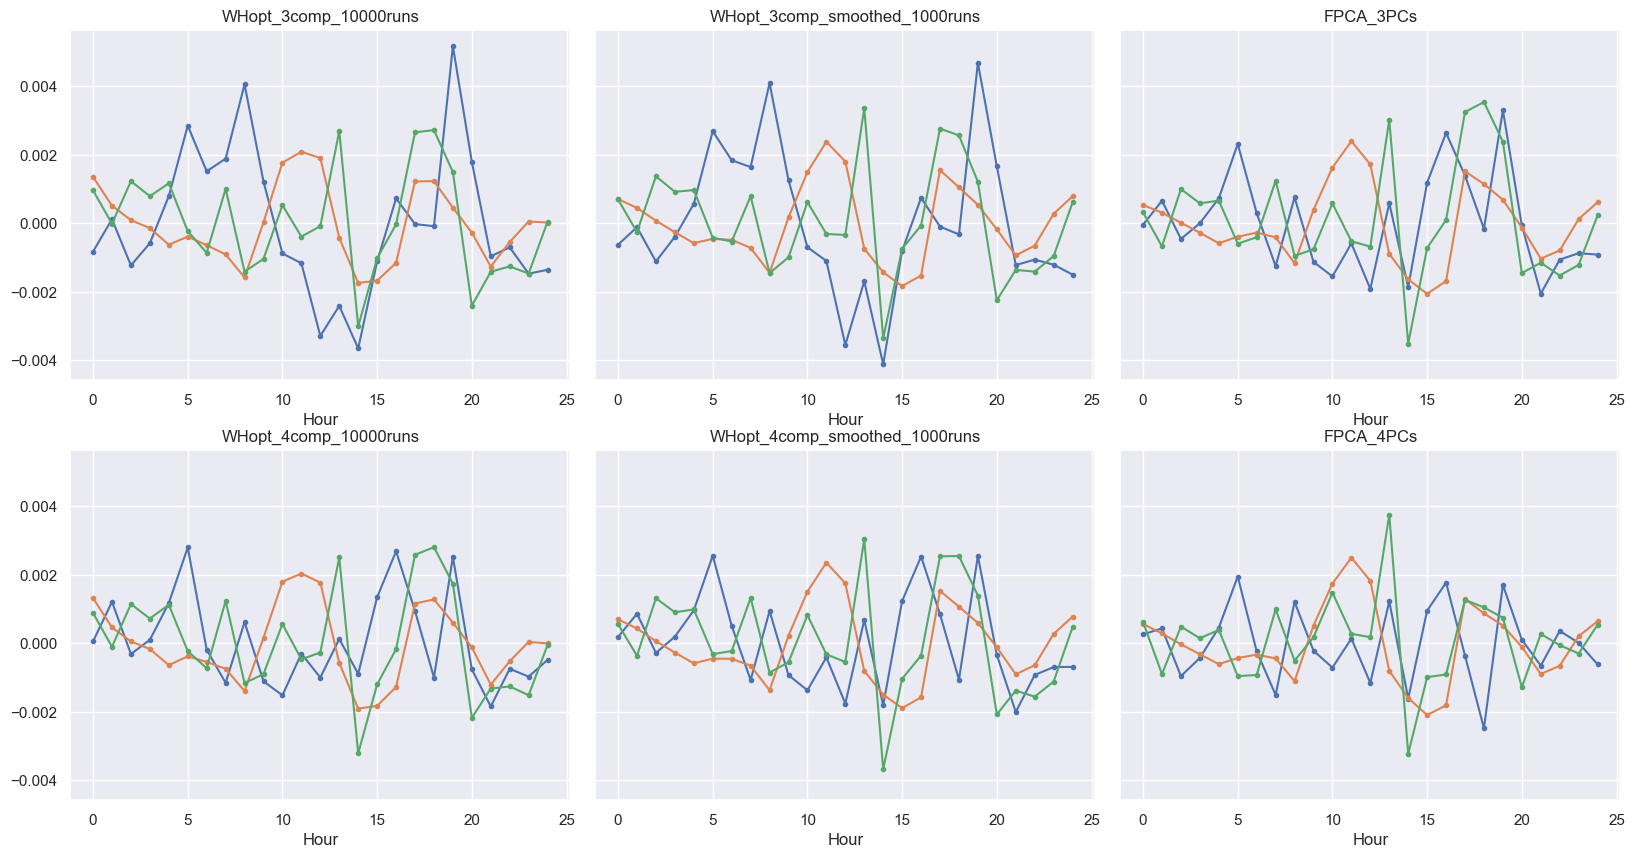

In [211]:
fig, axs = plot_residual_curves(residuals, n_curves_plotted=3, figsize=(20, 10), markersize=3)

## Residual histograms

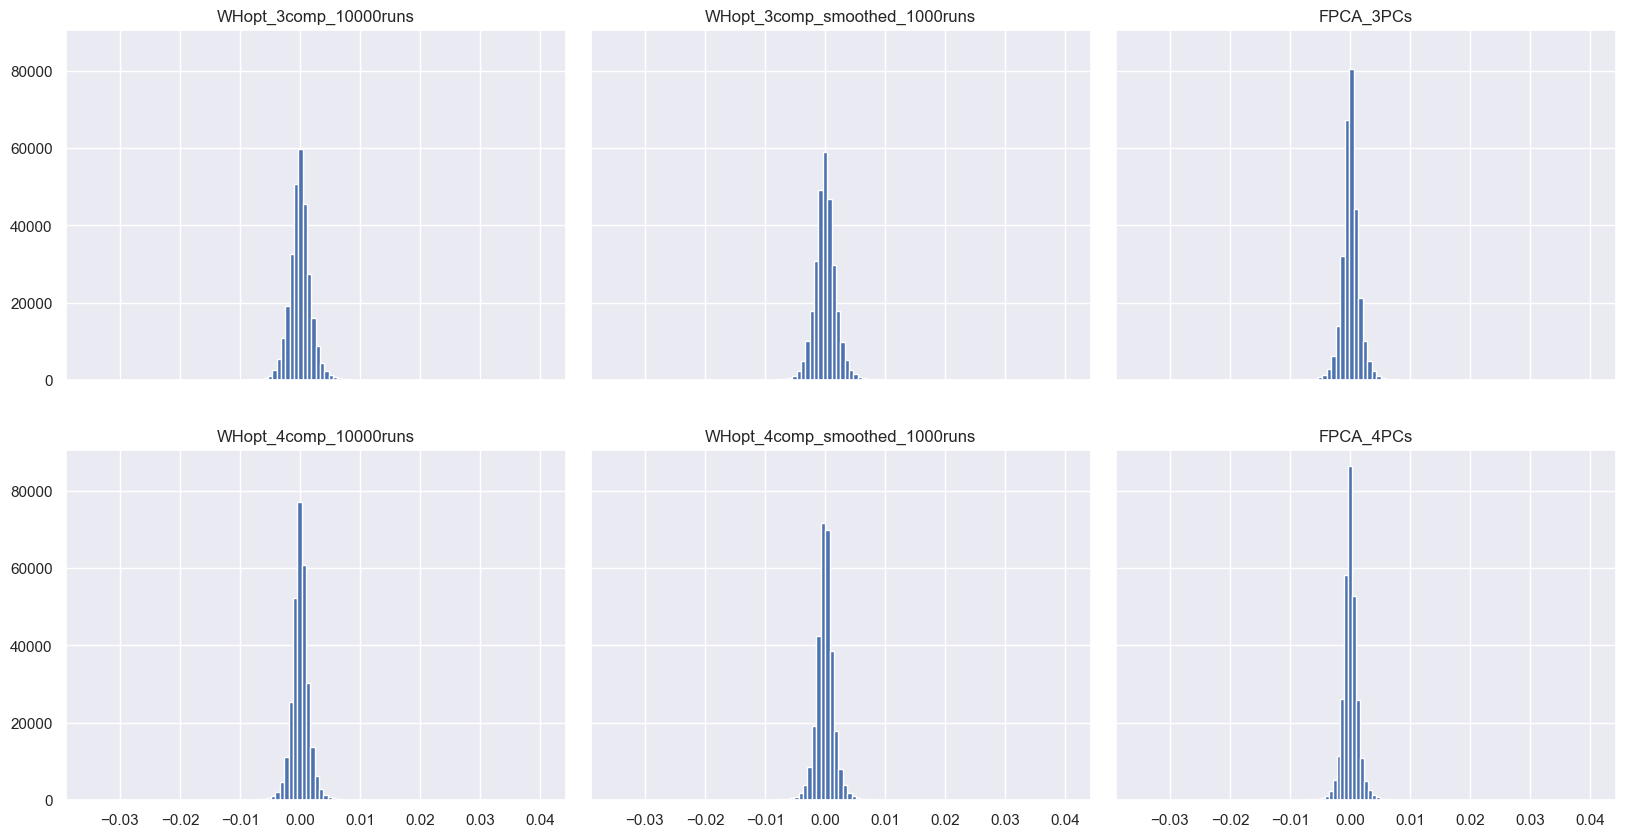

In [212]:
nrows = floor(sqrt(len(method_names)))
ncols = ceil(len(method_names) / nrows)

fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10), squeeze=False, sharex=True, sharey=True)

for idx, (method, E)  in enumerate(residuals.items()):
    resid = E.values.flatten()
    i = idx // ncols
    j = idx % ncols
    axs[i, j].hist(resid, bins=100)
    axs[i, j].set_title(method)
plt.subplots_adjust(wspace=0.05)

## Homoschedasticity

In [241]:
residuals_with_info = {}

for method in method_names:
    resid_df = pd.concat([residuals[method], unit_info], axis=1)
    resid_df = resid_df.melt(id_vars=info_cols, var_name='hour', value_name='residual')
    residuals_with_info[method] = resid_df

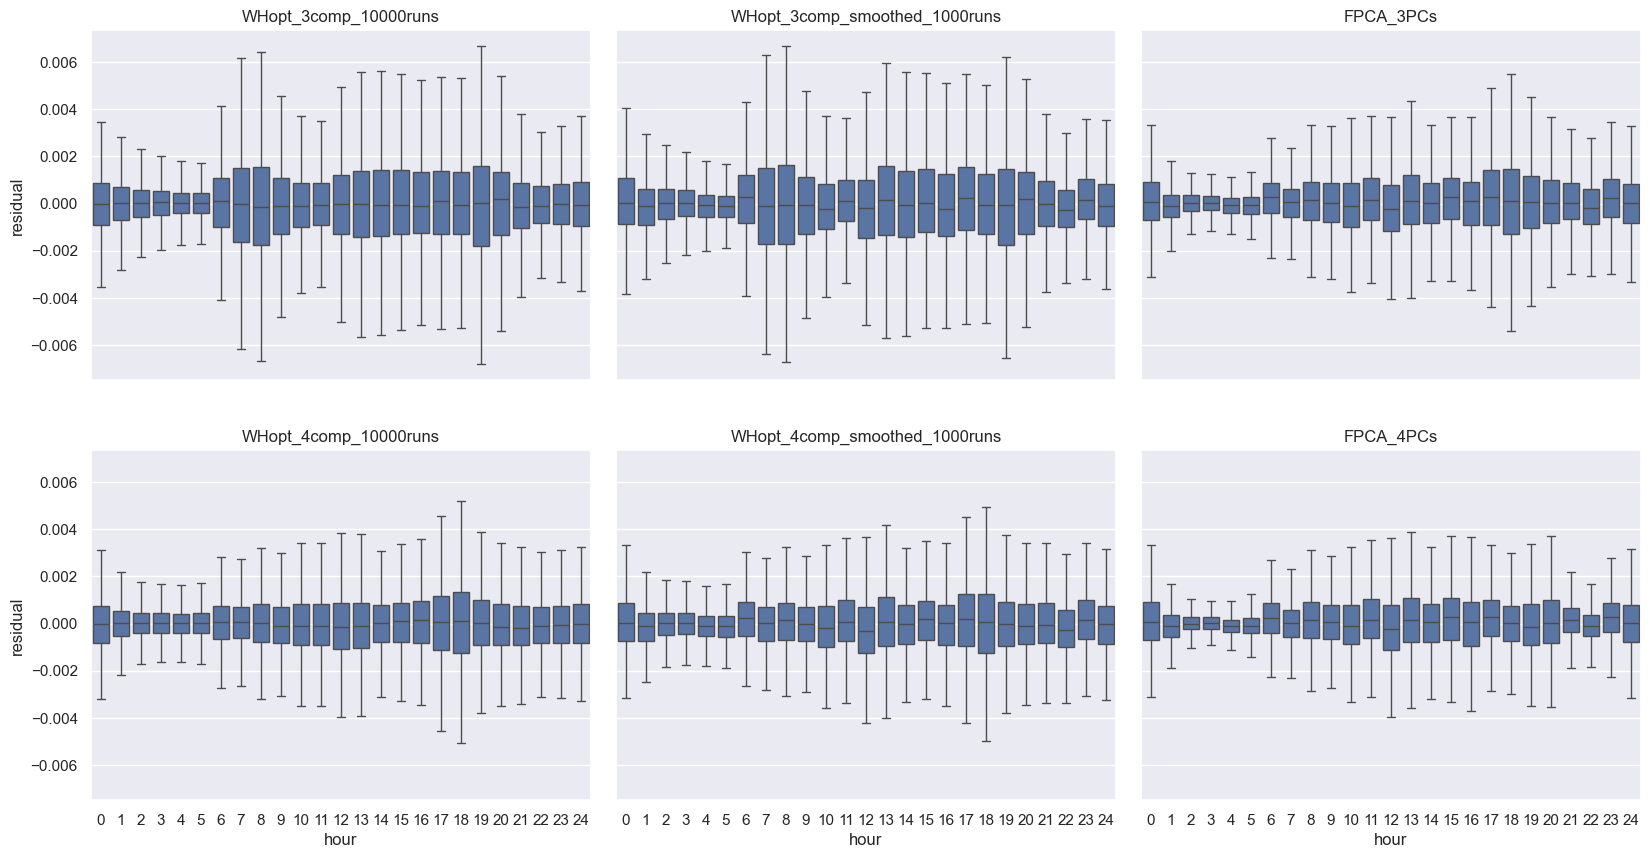

In [214]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='hour', showfliers=False, figsize=(20,10))

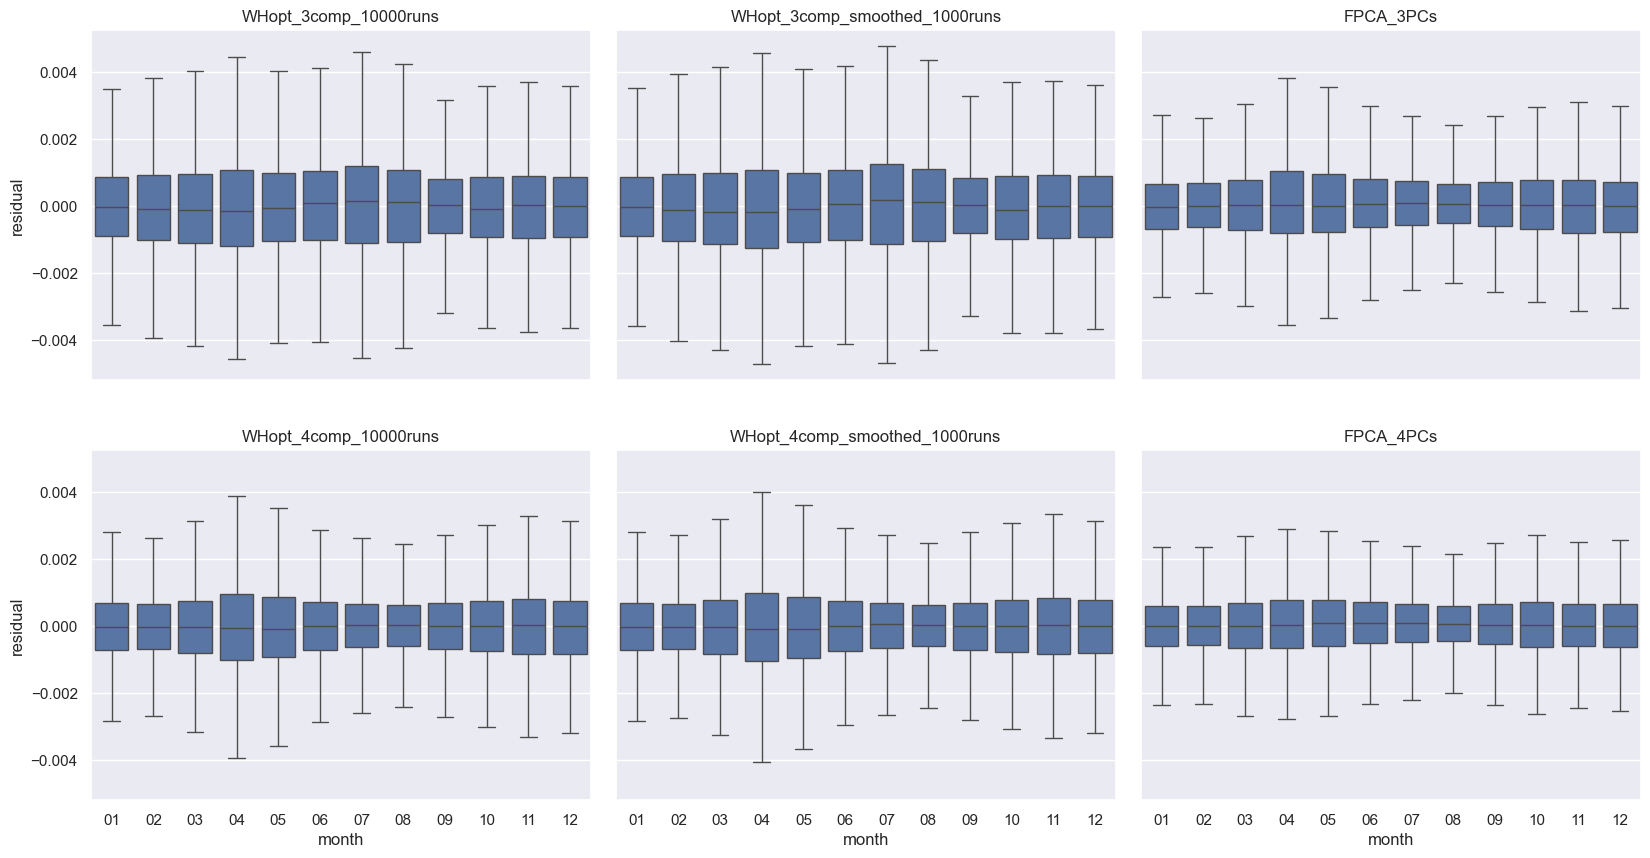

In [215]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='month', showfliers=False)

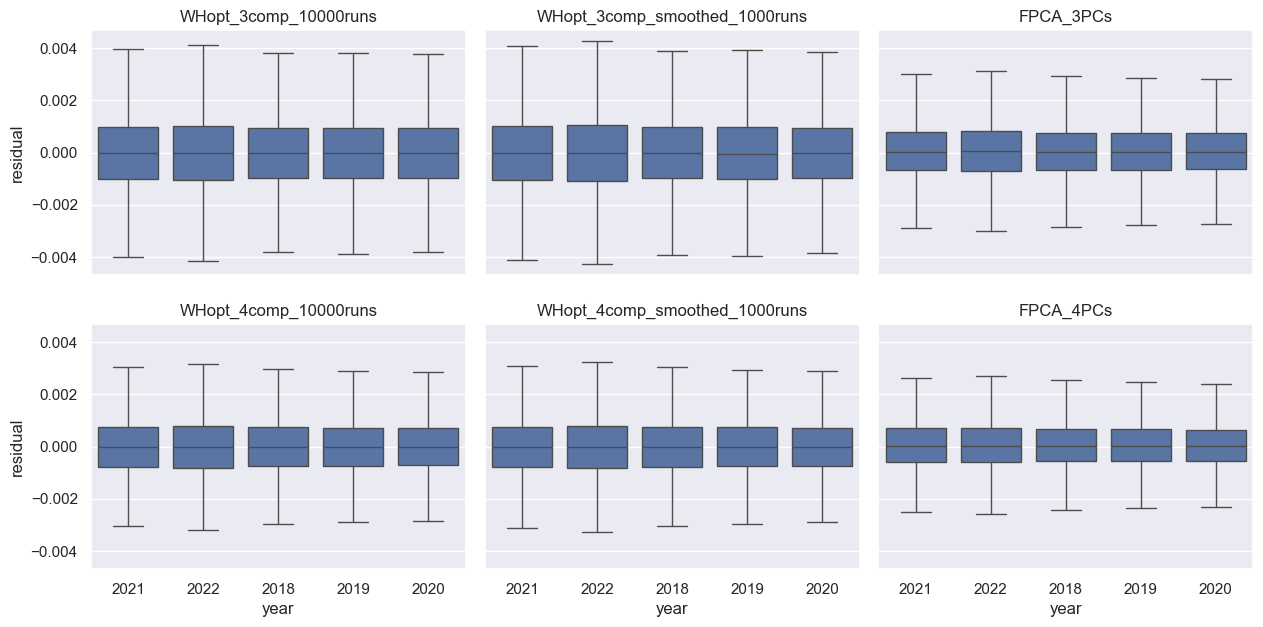

In [216]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='year', showfliers=False, figsize=(15,7))

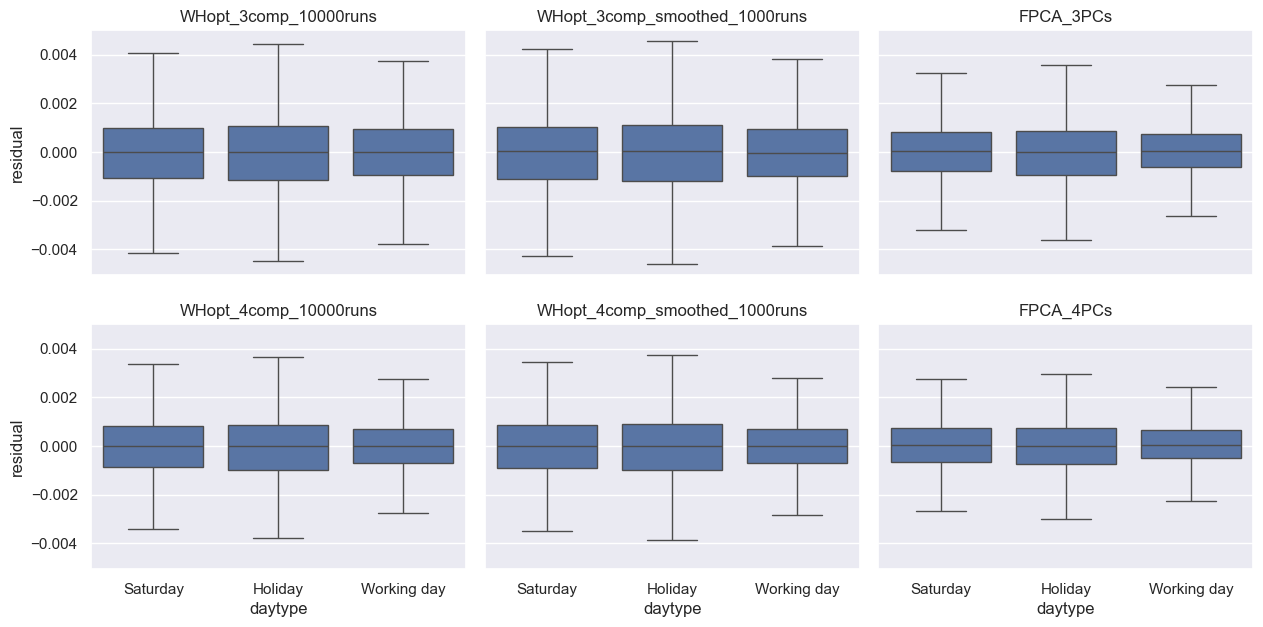

In [217]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='daytype', showfliers=False, figsize=(15,7))

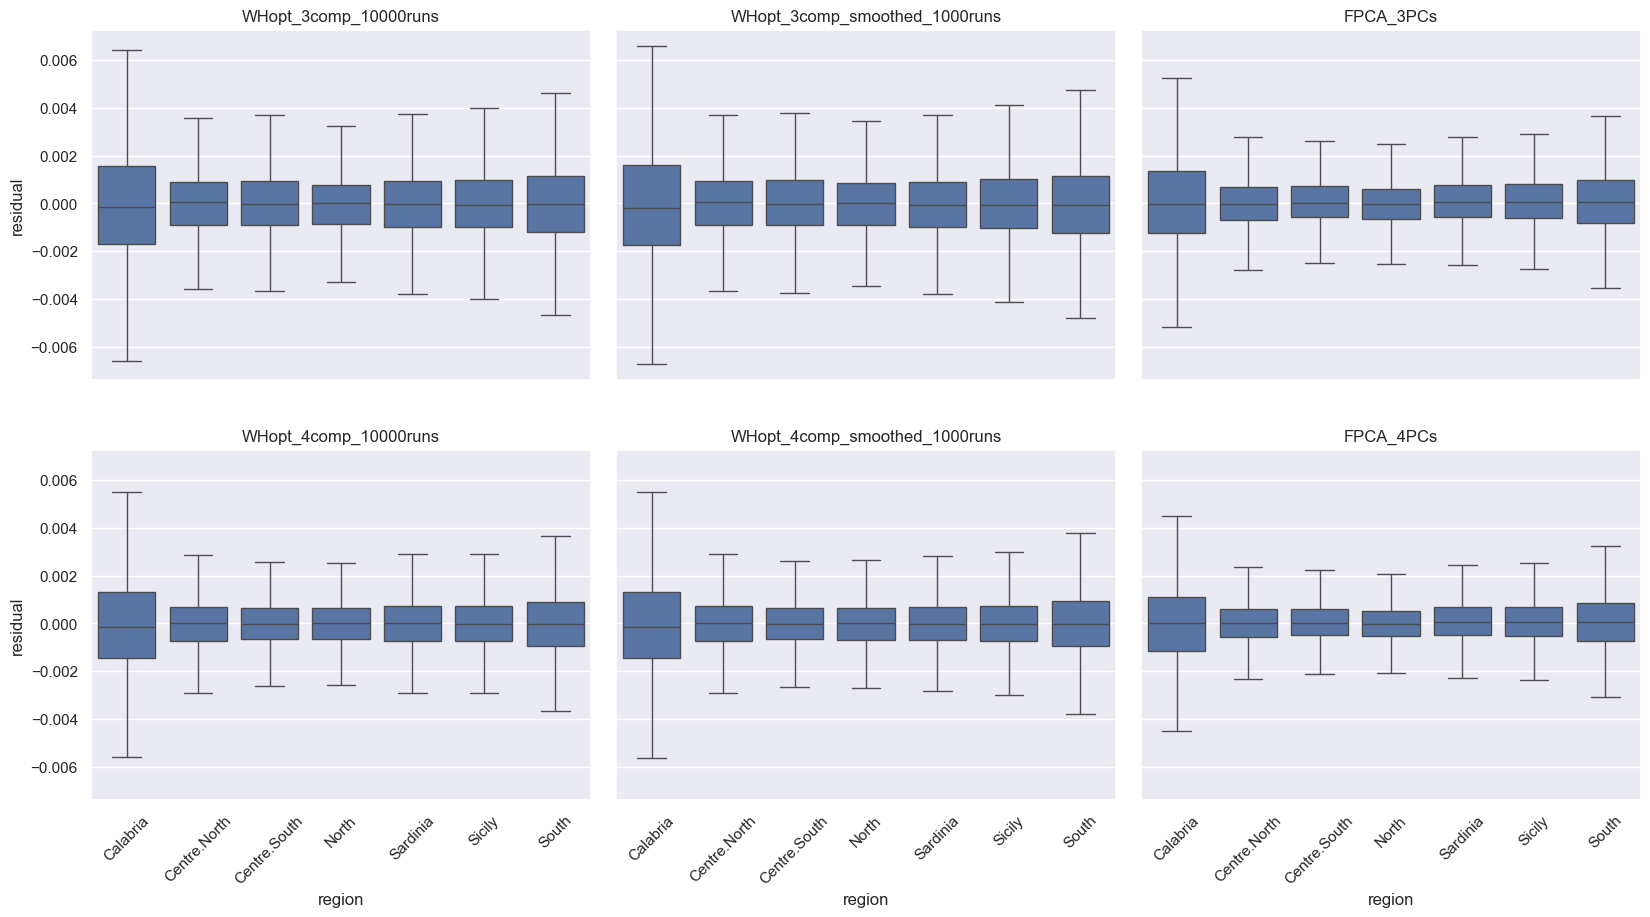

In [218]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='region', showfliers=False, rotate_xlabels=True)

# Compare model fit

In [219]:
print(method_names)

['WHopt_3comp_10000runs', 'WHopt_3comp_smoothed_1000runs', 'FPCA_3PCs', 'WHopt_4comp_10000runs', 'WHopt_4comp_smoothed_1000runs', 'FPCA_4PCs']


In [220]:
# Sample data for groups
method1 = 'FPCA_3PCs'
method2 = 'WHopt_4comp_smoothed_1000runs'

# Performing Levene's test
res1 = residuals_with_info[method1]['residual']
res2 = residuals_with_info[method2]['residual']
statistic, p_value = levene(res1, res2)

# Print estimated variance
print("Sum of squared residuals for {} is {:.4f} for {:,} samples".format(method1, (res1**2).sum(), len(res1)))
print("Sum of squared residuals for {} is {:.4f} for {:,} samples".format(method2, (res2**2).sum(), len(res2)))

# Checking the result
print("\nTest Statistic:", statistic)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print(f"\nReject the null hypothesis")
else:
    print(f"\nFail to reject the null hypothesis")

Sum of squared residuals for FPCA_3PCs is 0.6309 for 291,150 samples
Sum of squared residuals for WHopt_4comp_smoothed_1000runs is 0.6245 for 291,150 samples

Test Statistic: 30.377408985665827
p-value: 3.557960752193853e-08

Reject the null hypothesis


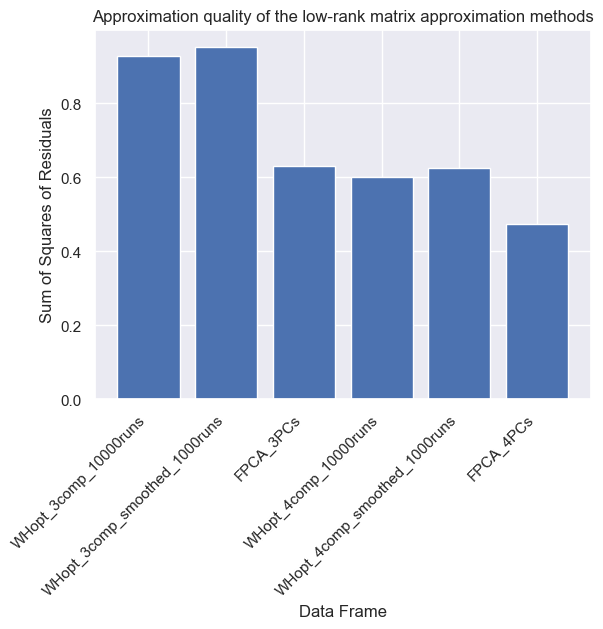

In [221]:
# Initialize lists to store data
labels = []
sums_of_squares = []

# Iterate over the dictionary of data frames
for key, res_df in residuals_with_info.items():
    # Calculate sum of squares of residuals
    sum_of_squares = (res_df['residual'] ** 2).sum()
    
    # Append to lists
    labels.append(key)
    sums_of_squares.append(sum_of_squares)

# Create bar plot
plt.bar(labels, sums_of_squares)
plt.xlabel('Data Frame')
plt.ylabel('Sum of Squares of Residuals')
plt.title('Approximation quality of the low-rank matrix approximation methods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Showing examples of reconstructed curves

In [222]:
method_names

['WHopt_3comp_10000runs',
 'WHopt_3comp_smoothed_1000runs',
 'FPCA_3PCs',
 'WHopt_4comp_10000runs',
 'WHopt_4comp_smoothed_1000runs',
 'FPCA_4PCs']

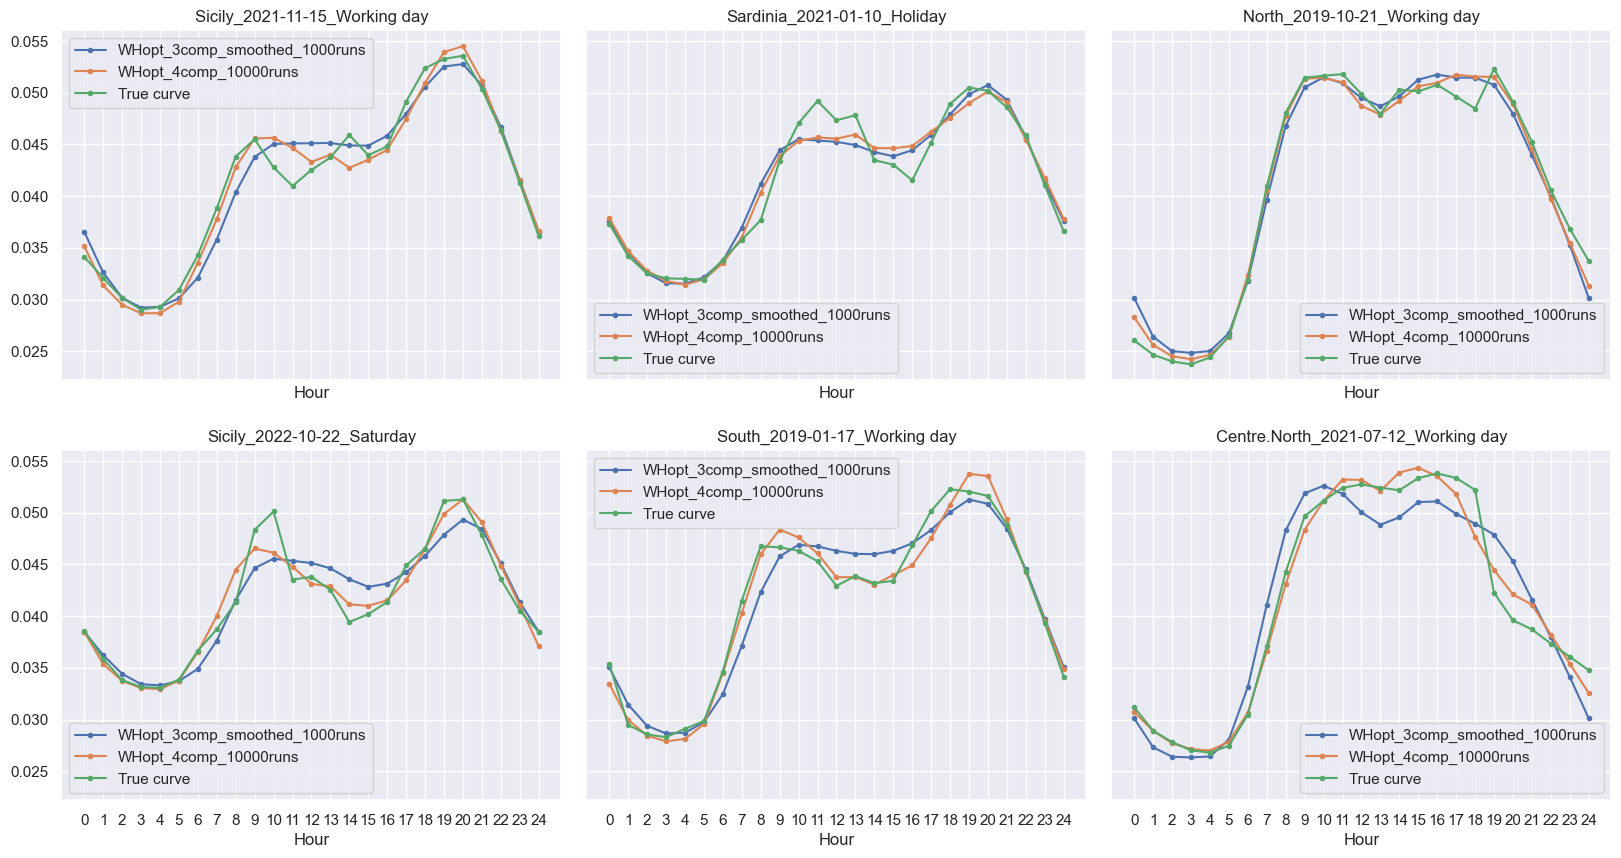

In [226]:
override_methods = ['WHopt_3comp_smoothed_1000runs', 'WHopt_4comp_10000runs']
fig, ax = plot_random_reconstructed(reconstructed, X, override_methods=override_methods, n_obs=6, figsize=(20,10), markersize=3)

# Analyse concentrations

In [242]:
W_with_info = {}
for method in nmf_method_names:
    W_df = pd.DataFrame(W[method], index=input_df.index, columns=[f"Component {k+1}" for k in range(W[method].shape[1])])
    W_df = pd.concat([W_df, unit_info], axis=1)
    W_with_info[method] = W_df.sort_values(['year', 'month', 'region'])

In [243]:
region_order = [
    'North',
    'Centre.North',
    'Sardinia',
    'Centre.South',
    'South',
    'Calabria',
    'Sicily'
]

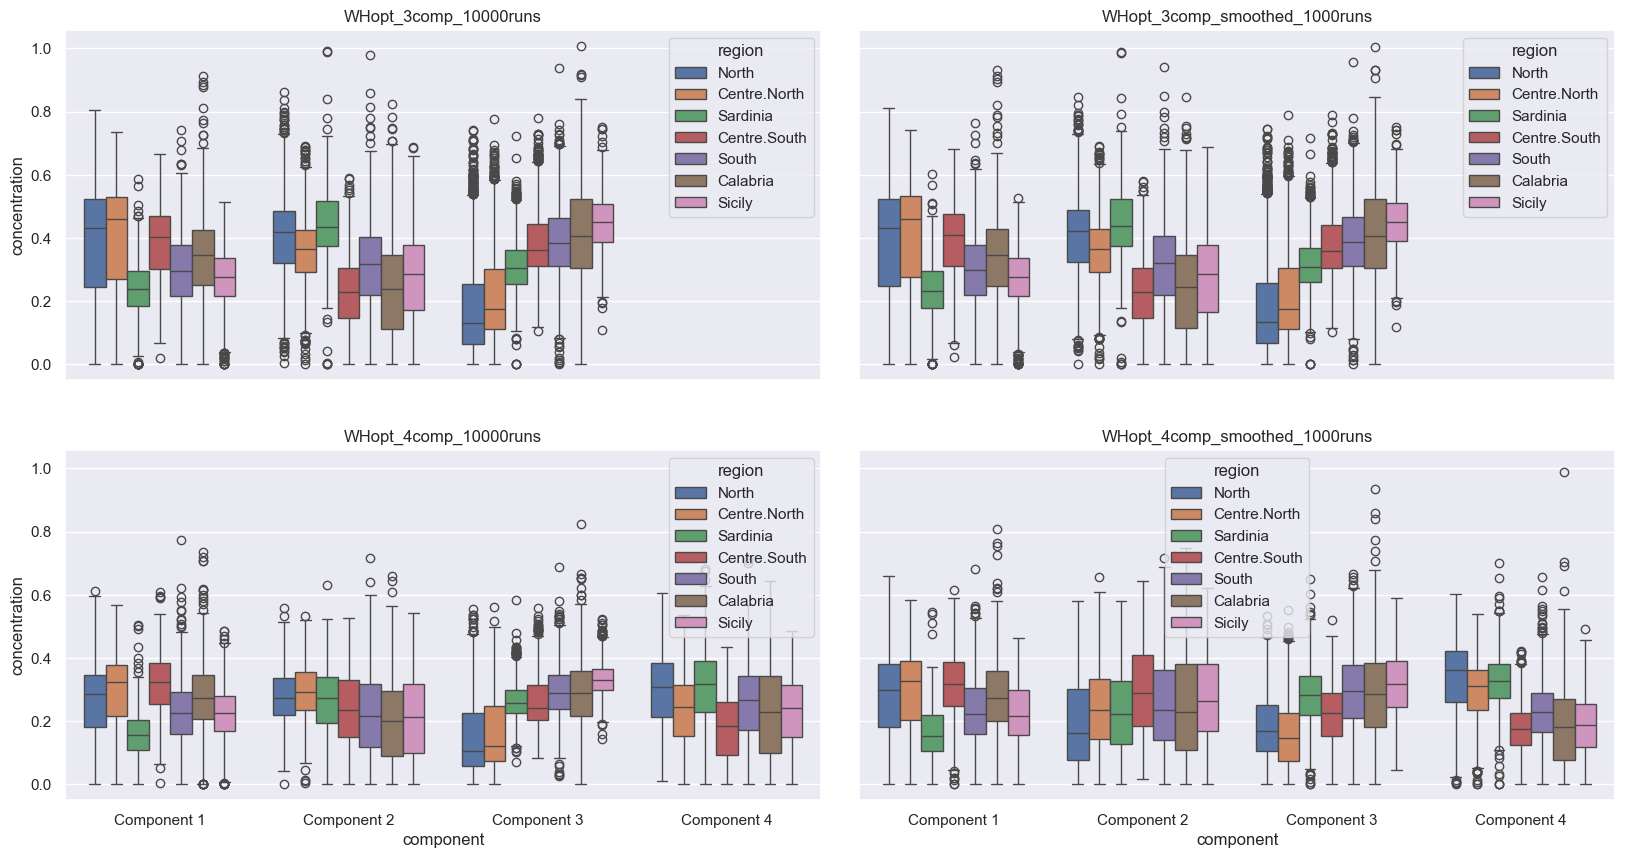

In [244]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='region', hue_order=region_order, figsize=(20,10),
                                    #    subplots_titles=['Distribution of Concentrations per Market Zone'], legend_position='upper right'
                                       )

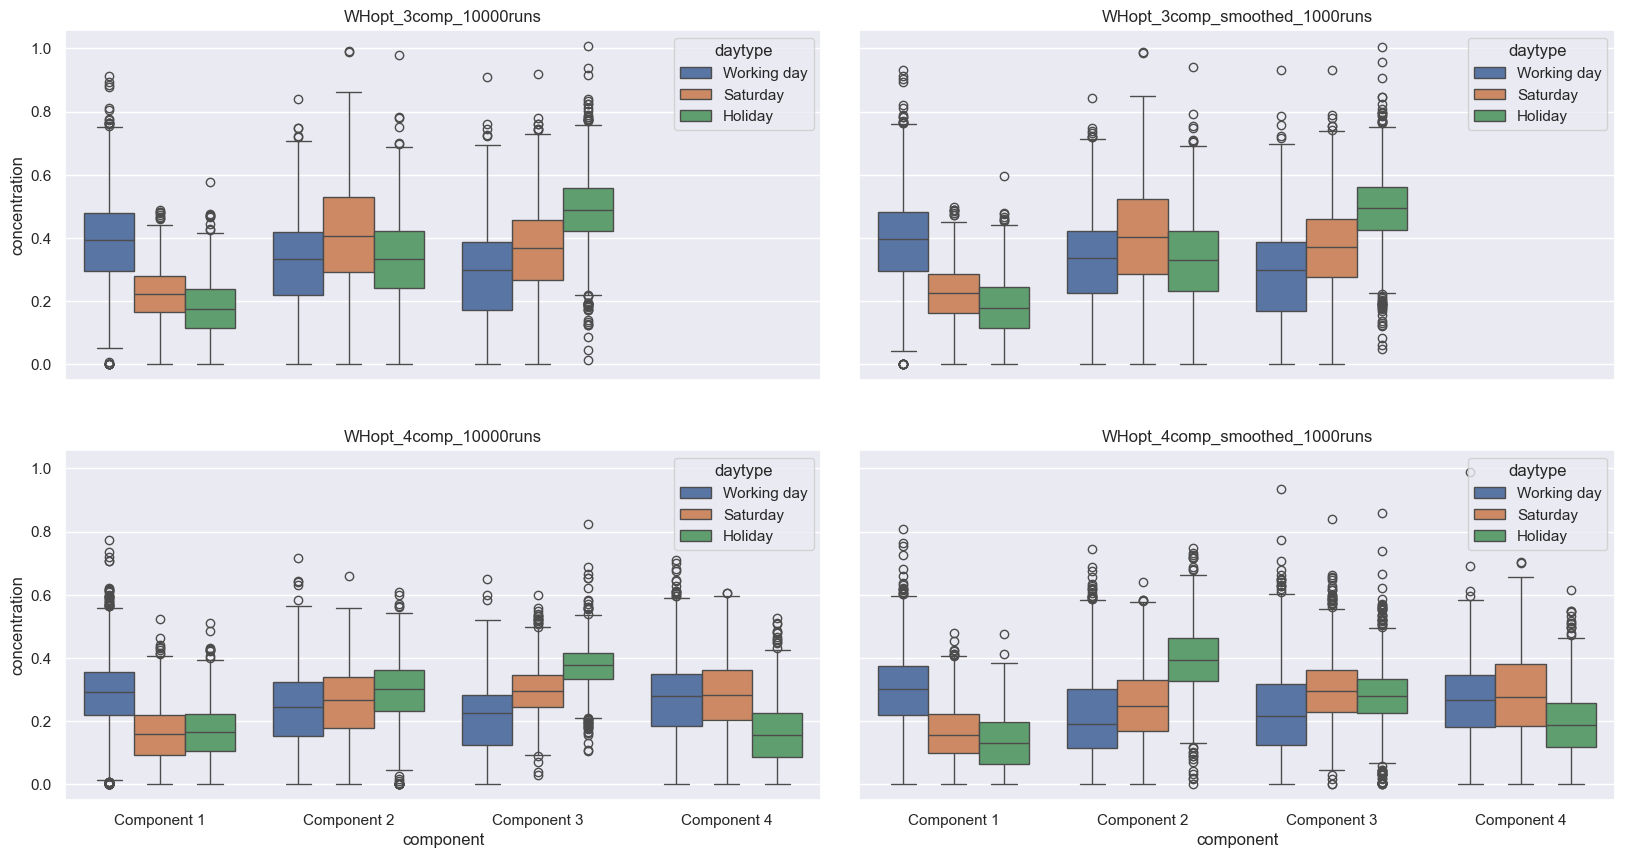

In [245]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='daytype', hue_order=['Working day', 'Saturday', 'Holiday'], figsize=(20,10),
                                    #    subplots_titles=['Distribution of Concentrations per Day Type'], legend_position='upper right'
                                       )

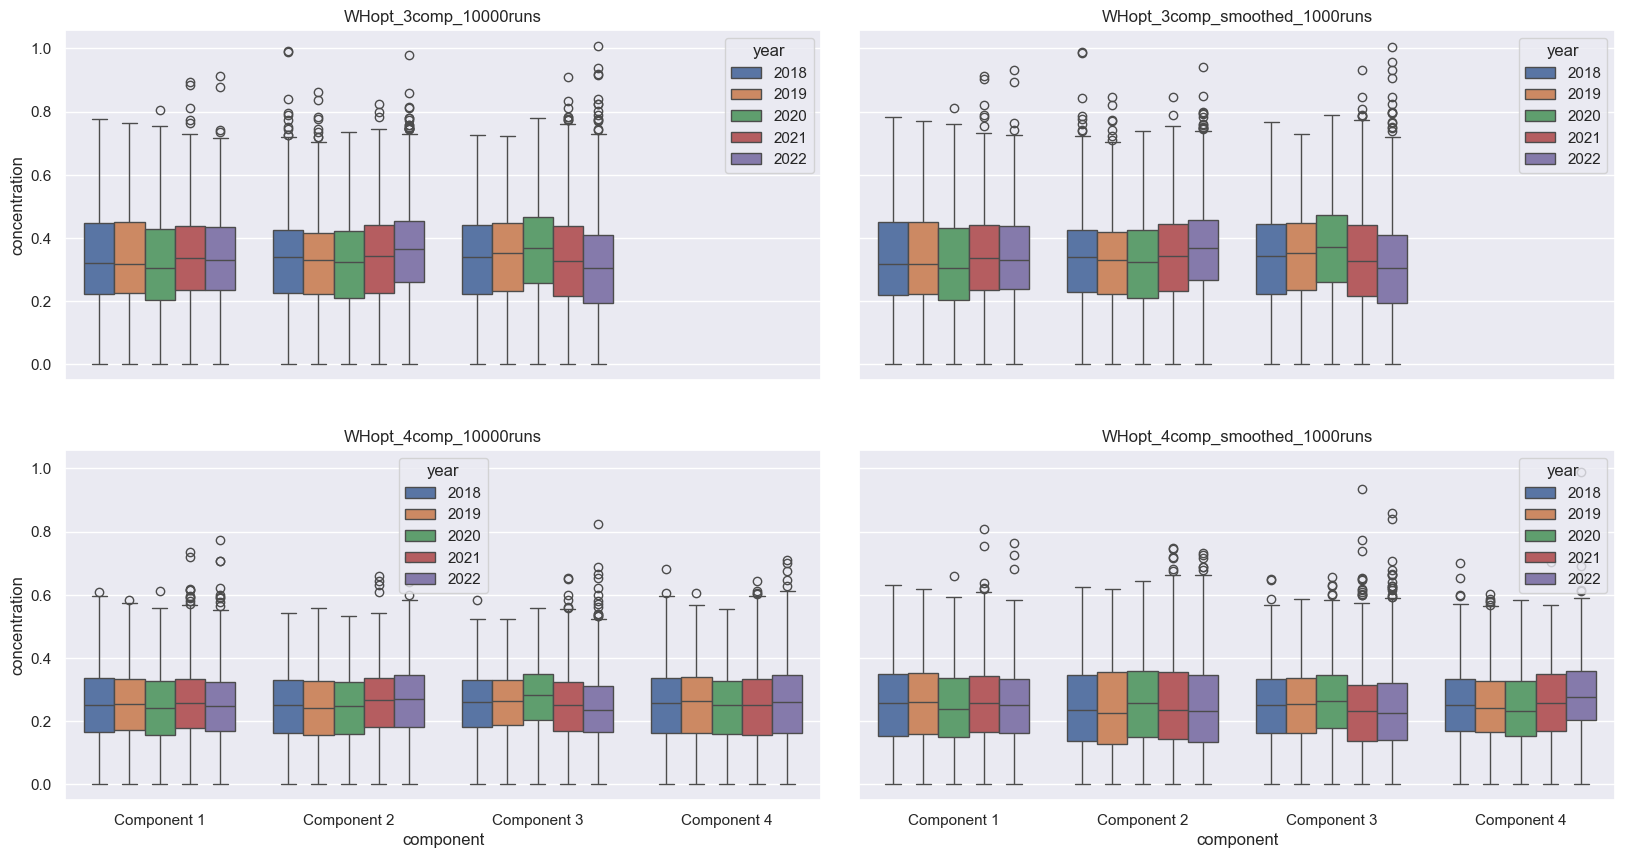

In [248]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='year', figsize=(20,10),
                                    #    subplots_titles=['Distribution of Concentrations per Year'], legend_position='upper right', ncols_legend=6
                                       )

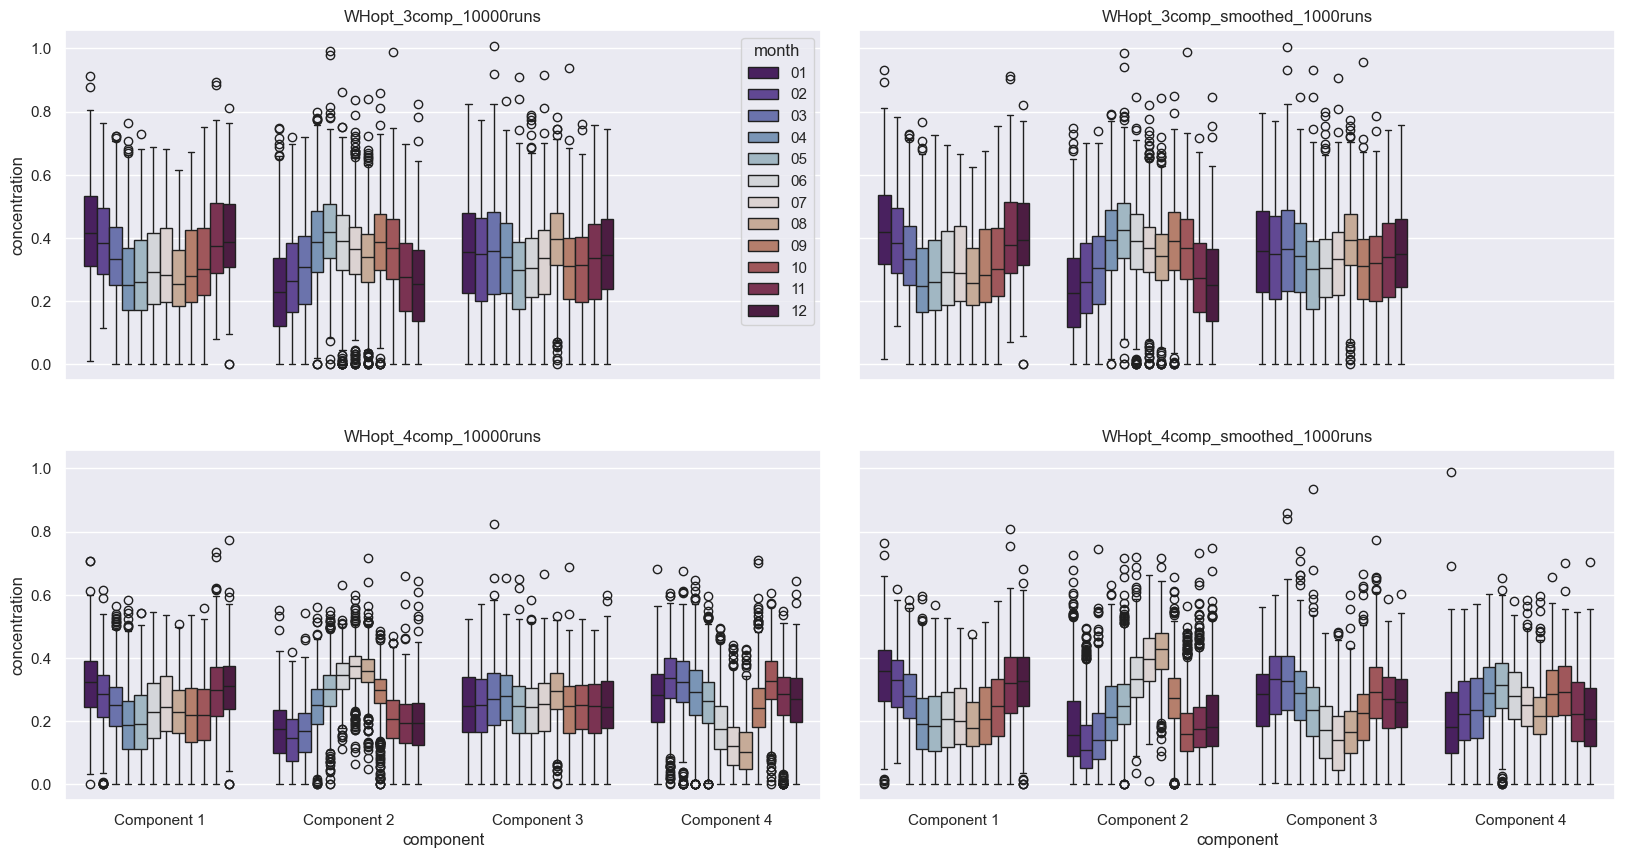

In [249]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='month', palette='twilight_shifted', replicate_legend=False, figsize=(20,10),
                                    #    subplots_titles=['Distribution of Concentrations per Month'], legend_position='upper right', ncols_legend=6
                                       )

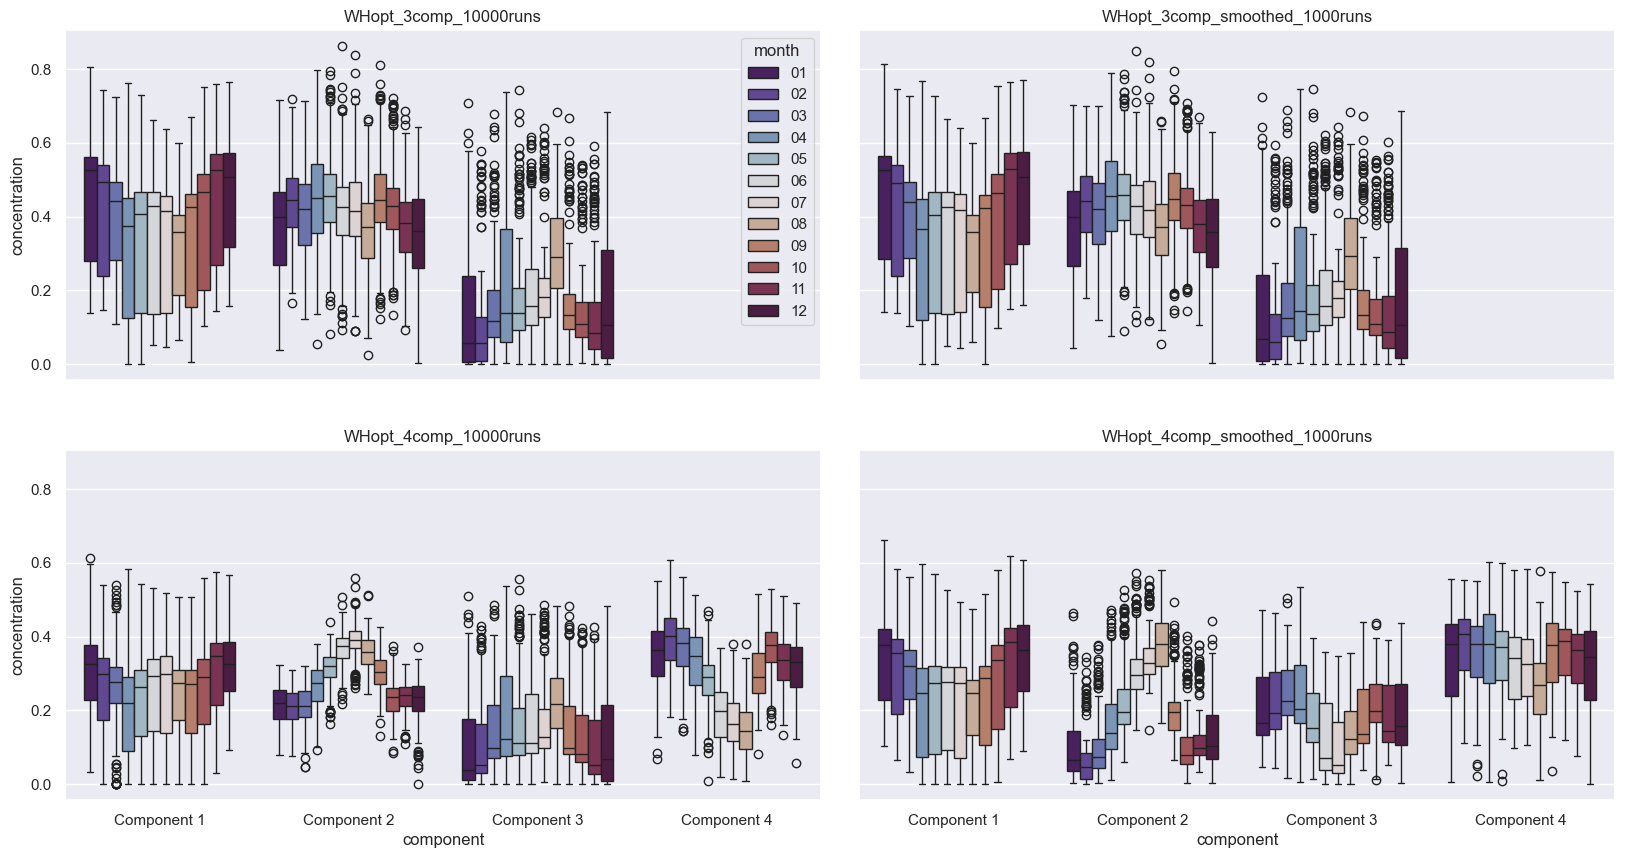

In [250]:
plot_dict = {key: df[df.region == 'North'] for key, df in W_with_info.items()}
fig, ax = plot_concentrations_boxplots(plot_dict, x='component', hue='month', palette='twilight_shifted', replicate_legend=False)

# Analyse deconvolution of the total load

In [254]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

method = 'WHopt_3comp_10000runs'
curves_comp = {}

for k in range(H[method].shape[0]):

    W_k = W[method][:, k]
    H_k = H[method][k, :]

    curves_k = (norm_X * W_k).values.reshape((len(norm_X), 1)).dot(H_k.reshape((1, H_k.shape[0])))
    # We squeeze the 25th point corresponding to hour 24:00 of day d because it is at the same moment of 00:00 of day d+1 and we want a unique value per time instant
    curves_k = pd.DataFrame(curves_k[:,:-1], columns=range(H_k.shape[0]-1), index=X_unnorm.index)
    curves_k['date'] = curves_k.index.str.split('_').str[1]
    curves_k = pd.concat([curves_k, unit_info], axis=1)

    curves_comp[f'Component {k + 1}'] = curves_k

curves_comp['Component 1']

0           1           2  \
Calabria_2021-01-02_Saturday     106.492613   93.652551   89.872335   
Calabria_2021-01-03_Holiday      130.591441  114.845727  110.210065   
Calabria_2021-01-04_Working day  212.208946  186.622420  179.089545   
Calabria_2021-01-05_Working day  152.448022  134.067010  128.655494   
Calabria_2021-01-06_Holiday      148.855512  130.907657  125.623666   
...                                     ...         ...         ...   
South_2022-12-26_Holiday         219.213889  192.782761  185.001228   
South_2022-12-27_Working day     597.700603  525.634452  504.417607   
South_2022-12-28_Working day     816.205322  717.793549  688.820345   
South_2022-12-29_Working day     405.547470  356.649669  342.253770   
South_2022-12-30_Working day     479.008231  421.253095  404.249526   

                                          3           4           5  \
Calabria_2021-01-02_Saturday      89.990711   94.339259  107.065320   
Calabria_2021-01-03_Holiday      110.355229  115.687834  131.293750   
Calabria_2021-01-04_Working day  179.325433  187.990830  213.350186   
Calabria_2021-01-05_Working day  128.824954  135.050057  153.267874   
Calabria_2021-01-06_Holiday      125.789132  131.867538  149.656043   
...                                     ...         ...         ...   
South_2022-12-26_Holiday         185.244903  194.196342  220.392801   
South_2022-12-27_Working day     505.082004  529.488669  600.914981   
South_2022-12-28_Working day     689.727629  723.056774  820.594799   
South_2022-12-29_Working day     342.704571  359.264805  407.728467   
South_2022-12-30_Working day     404.781986  424.341936  481.584293   

                                           6            7            8  \
Calabria_2021-01-02_Saturday      152.262029   214.426799   262.555900   
Calabria_2021-01-03_Holiday       186.718283   262.950677   321.971191   
Calabria_2021-01-04_Working day   303.414142   427.290530   523.197895   
Calabria_2021-01-05_Working day   217.968595   306.959708   375.858256   
Calabria_2021-01-06_Holiday       212.832061   299.726056   367.000976   
...                                      ...          ...          ...   
South_2022-12-26_Holiday          313.429737   441.395241   540.468475   
South_2022-12-27_Working day      854.586101  1203.492181  1473.621650   
South_2022-12-28_Working day     1167.001875  1643.459483  2012.341678   
South_2022-12-29_Working day      579.847552   816.584770   999.871055   
South_2022-12-30_Working day      684.880983   964.500718  1180.987432   

                                           9  ...           19           20  \
Calabria_2021-01-02_Saturday      286.648230  ...   280.334621   250.803983   
Calabria_2021-01-03_Holiday       351.515514  ...   343.773161   307.559865   
Calabria_2021-01-04_Working day   571.206935  ...   558.625739   499.779728   
Calabria_2021-01-05_Working day   410.347297  ...   401.309137   359.034963   
Calabria_2021-01-06_Holiday       400.677267  ...   391.852096   350.574132   
...                                      ...  ...          ...          ...   
South_2022-12-26_Holiday          590.062276  ...   577.065779   516.277281   
South_2022-12-27_Working day     1608.842301  ...  1573.406528  1407.662824   
South_2022-12-28_Working day     2196.995691  ...  2148.605466  1922.269919   
South_2022-12-29_Working day     1091.619989  ...  1067.576365   955.117152   
South_2022-12-30_Working day     1289.355742  ...  1260.956863  1128.126818   

                                          21           22           23  \
Calabria_2021-01-02_Saturday      217.725395   189.392790   164.560525   
Calabria_2021-01-03_Holiday       266.995732   232.251578   201.799876   
Calabria_2021-01-04_Working day   433.863678   377.404998   327.921484   
Calabria_2021-01-05_Working day   311.681769   271.122621   235.574336   
Calabria_2021-01-06_Holiday       304.336839   264.733486   230.022914   
...                                      ...          

In [255]:
load_comp = {}

for k in range(H[method].shape[0]):
    comp = f'Component {k + 1}'
    load_comp[comp] = curves_comp[comp].melt(id_vars=['date']+info_cols, var_name='hour', value_name='load')

    # Convert 'date' column to datetime format
    load_comp[comp]['date'] = pd.to_datetime(load_comp[comp]['date'])

    # Construct datetime column by adding the hour column as timedelta
    load_comp[comp]['datetime'] = load_comp[comp]['date'] + pd.to_timedelta(load_comp[comp]['hour'], unit='h')
    load_comp[comp].set_index('datetime', inplace=True)
    load_comp[comp].sort_values(['region', 'date', 'hour'], inplace=True)

load_comp['Component 1']

date    region  year month      daytype hour  \
datetime                                                                 
2021-01-02 00:00:00 2021-01-02  Calabria  2021    01     Saturday    0   
2021-01-02 01:00:00 2021-01-02  Calabria  2021    01     Saturday    1   
2021-01-02 02:00:00 2021-01-02  Calabria  2021    01     Saturday    2   
2021-01-02 03:00:00 2021-01-02  Calabria  2021    01     Saturday    3   
2021-01-02 04:00:00 2021-01-02  Calabria  2021    01     Saturday    4   
...                        ...       ...   ...   ...          ...  ...   
2022-12-30 19:00:00 2022-12-30     South  2022    12  Working day   19   
2022-12-30 20:00:00 2022-12-30     South  2022    12  Working day   20   
2022-12-30 21:00:00 2022-12-30     South  2022    12  Working day   21   
2022-12-30 22:00:00 2022-12-30     South  2022    12  Working day   22   
2022-12-30 23:00:00 2022-12-30     South  2022    12  Working day   23   

                            load  
datetime                          
2021-01-02 00:00:00   106.492613  
2021-01-02 01:00:00    93.652551  
2021-01-02 02:00:00    89.872335  
2021-01-02 03:00:00    89.990711  
2021-01-02 04:00:00    94.339259  
...                          ...  
2022-12-30 19:00:00  1260.956863  
2022-12-30 20:00:00  1128.126818  
2022-12-30 21:00:00   979.337944  
2022-12-30 22:00:00   851.896699  
2022-12-30 23:00:00   740.200131  

[279504 rows x 7 columns]

In [256]:
component = 'Component 1'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]

fig = px.line(
    df_plot,
    x = df_plot.index,
    y = 'load',
    #line_group='Bidding zone',
    title = f'Total Load Evolution of {component} for region {region} [MW]',
    height = 1000
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Load')
fig.show()

In [272]:
year_cmap = {year: seq_colors[k] for k, year in enumerate(np.sort(df.year.unique()))}
year_cmap

{'2018': (0.20973515, 0.09747934, 0.24238489),
 '2019': (0.43860848, 0.12177004, 0.34119475),
 '2020': (0.67824099, 0.09192342, 0.3504148),
 '2021': (0.8833417, 0.19830556, 0.26014181),
 '2022': (0.95381595, 0.46373781, 0.31769923)}

In [271]:
np.sort(df.year.unique())

array(['2018', '2019', '2020', '2021', '2022'], dtype=object)

In [276]:
df_plot.year.unique()

array(['2018', '2019', '2020', '2021', '2022'], dtype=object)

In [277]:
component = 'Component 1'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]
# df_plot['year'] = df_plot['year'].astype(int)

fig = px.bar(
    df_plot.groupby(['region', 'year', 'month'], as_index=False)['load'].sum(),
    x = 'month',
    y = 'load',
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group',
    # color_discrete_map=year_cmap
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

In [278]:
component = 'Component 2'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]

fig = px.bar(
    df_plot.groupby(['region', 'year', 'month'], as_index=False)['load'].sum(),
    x = 'month',
    y = 'load',
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

In [279]:
component = 'Component 3'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]

fig = px.bar(
    df_plot.groupby(['region', 'year', 'month'], as_index=False)['load'].sum(),
    x = 'month',
    y = 'load',
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()

In [146]:
component = 'Component 4'
region = 'North'
df_plot = load_comp[component]
df_plot = df_plot[df_plot.region == region]

fig = px.bar(
    df_plot.groupby(['region', 'year', 'month'], as_index=False)['load'].sum(),
    x = 'month',
    y = 'load',
    color='year',
    title = f'Total monthly consumption of {component} for region {region} [MWh]',
    height = 500,
    barmode='group'
)

fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Consumption')
fig.show()